In [1]:
import numpy as np
import pickle
import math
import cmath
import scipy 
import scipy.linalg
import scipy.integrate
import sys
import tqdm
import warnings
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline

import MolmerSorensonLibrary


/Users/joseph/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
calculated_results_filestr = "calculated_results_file.pkl"

In [3]:
results_storage = {}

In [4]:
eta=0.1
energy_vibrational = .1

initial_number_vibrational_states = 12

rabi_energy = .10 * energy_vibrational 

laser_detuning_delta_energy = .90 * energy_vibrational
laser_energy_1 = laser_detuning_delta_energy
laser_energy_2 = -laser_detuning_delta_energy


c_0 = 1.0

num_expts = 30
c_1_values_temp = np.logspace(-4, -1, num_expts - 1)
c_1_values = np.zeros(num_expts)
c_1_values[0] = 0.0
c_1_values[1:] = c_1_values_temp

vibrational_frequency_cycles = 7000.0 / (2.0 * np.pi)#will multiply the frequency of the lowest frequency mode to get the max time


In [5]:
for c_1 in c_1_values:
    if c_1 in results_storage:
        print("c_2 = %f already calculated, moving along..." %c_1)
        continue
    c_list = [c_0, c_1]
    MS_system = MolmerSorensonLibrary.MolmerSorenson(
                    number_vibrational_states = initial_number_vibrational_states,
                    energy_vibrational = energy_vibrational, 
                    eta_values_list = [eta, eta], 
                    transition_dipole_c_values = c_list)
    
    barN_equals_2_CSgen = lambda : MS_system.coherent_vibrational_state_ground_electronic( math.sqrt(2))
    
    
    t, results = MS_system.propagate(laser_energy_list_of_lists=[[laser_energy_1, laser_energy_2], [laser_energy_1, laser_energy_2]], 
                                  rabi_energy_list_of_lists=[[rabi_energy, rabi_energy], [rabi_energy, rabi_energy]],
                                  initial_state_generator = barN_equals_2_CSgen,
                            max_time_vibrational_cycles =vibrational_frequency_cycles)
    results_storage[c_1] = MS_system
    #in case it got bigger...
    initial_number_vibrational_states = MS_system.number_vibrational_states

100%|██████████| 230616/230616 [01:56<00:00, 1971.94it/s]


In [6]:
#Calculate Heating
heating_signals = []
for i, c_1 in enumerate(c_1_values):
    print(c_1)
    MS_system = results_storage[c_1]
    
    heating_trace = MS_system.average_vibrational_quanta()
    
    signal =  heating_trace
    heating_signals.append(signal)

0.0


MolmerSorensonLibrary.py:416: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self.propagated_results == None:


0.0001
0.0001279802214
0.000163789370695
0.000209617999245
0.000268269579528
0.000343332001828
0.000439397056076
0.00056234132519
0.000719685673001
0.000921055317689
0.00117876863479
0.0015085907086
0.00193069772888
0.00247091122799
0.00316227766017
0.00404708995076
0.00517947467923
0.00662870316183
0.00848342898244
0.010857111194
0.0138949549437
0.0177827941004
0.0227584592607
0.0291263265491
0.0372759372031
0.0477058269614
0.0610540229659
0.0781370737652
0.1


In [7]:
#Calculate Fidelity
fidelity_signals = []
gg_population_signals = []
ee_population_signals = []
for i, c_1 in enumerate(c_1_values):
    print(c_1)
    MS_system = results_storage[c_1]

    t = MS_system.time_values
    
    e_red_density_matrix = MS_system.reduced_electronic_density_matrix()
    gg_population_signals.append(e_red_density_matrix[:,0,0])
    ee_population_signals.append(e_red_density_matrix[:,-1,-1])
    rabi_energy_effective = MS_system.effective_rabi_energy(eta=eta, 
                                       laser_detuning = laser_detuning_delta_energy, 
                                       laser_rabi_energy = rabi_energy) 
    expected_density_matrix = MS_system.expected_unitary_dynamics(expected_rabi_energy = rabi_energy_effective,   
                                                            initial_density_matrix = e_red_density_matrix[0],
                                                            time_values = t)
    fidelity_time_trace = MS_system.fidelity(expected_density_matrix, e_red_density_matrix)
    
    signal =  fidelity_time_trace
    fidelity_signals.append(signal**2)



0.0


MolmerSorensonLibrary.py:396: ComplexWarning: Casting complex values to real discards the imaginary part
  new_fidelity = math.sqrt(self.trace(rho_product) + 2 * math.sqrt(rho_1_det * rho_2_det))


0.0001
0.0001279802214
0.000163789370695
0.000209617999245
0.000268269579528
0.000343332001828
0.000439397056076
0.00056234132519
0.000719685673001
0.000921055317689
0.00117876863479
0.0015085907086
0.00193069772888
0.00247091122799
0.00316227766017
0.00404708995076
0.00517947467923
0.00662870316183
0.00848342898244
0.010857111194
0.0138949549437
0.0177827941004
0.0227584592607
0.0291263265491
0.0372759372031
0.0477058269614
0.0610540229659
0.0781370737652
0.1


In [8]:
#Stuff for plotting
def moving_average( a, window_size) :
    output = np.convolve(a, np.ones((window_size,))/window_size, mode='valid')
    return output

window_size = 5000
def find_inf(list_in, replacement):
    output = []
    for item in list_in:
        if np.isinf(item):
            item = replacement
        output.append(item)
    return output

scale = np.log10(c_1_values)
label_scale = find_inf(scale, r"$-\infty$")
colorbar_Scale = find_inf(scale, scale[1] - 1)
# colorbar_Scale = scale

cNorm  = matplotlib.colors.Normalize(vmin=np.min(colorbar_Scale), vmax=np.max(colorbar_Scale))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('winter'))


/Users/joseph/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10


0.0


/Users/joseph/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


0.0001
0.0001279802214
0.000163789370695
0.000209617999245
0.000268269579528
0.000343332001828
0.000439397056076
0.00056234132519
0.000719685673001
0.000921055317689
0.00117876863479
0.0015085907086
0.00193069772888
0.00247091122799
0.00316227766017
0.00404708995076
0.00517947467923
0.00662870316183
0.00848342898244
0.010857111194
0.0138949549437
0.0177827941004
0.0227584592607
0.0291263265491
0.0372759372031
0.0477058269614
0.0610540229659
0.0781370737652
0.1


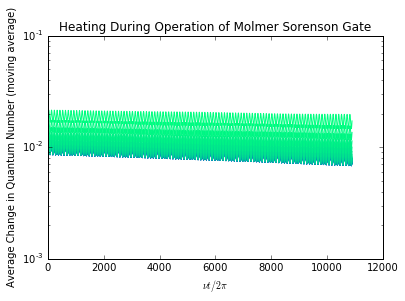

In [9]:
for i, c_1 in enumerate(c_1_values):
    print(c_1)
    MS_system = results_storage[c_1]

    t = MS_system.time_values
    t_plot = t[0:-window_size+1]
    
    signal = moving_average(heating_signals[i], window_size)

    colorVal = scalarMap.to_rgba(colorbar_Scale[i])
    plt.semilogy(t_plot, signal - 2, label=label_scale[i], color = colorVal)
# plt.legend(loc=0, fancybox=True,shadow=True, title=r"$\log \left(c_1\right)$")
plt.title("Heating During Operation of Molmer Sorenson Gate")
plt.ylabel("Average Change in Quantum Number (moving average)")
plt.xlabel(r"$\nu t / 2\pi$")
plt.savefig("MS_heating_cComparison_c1.png")

0.0
0.0001
0.0001279802214
0.000163789370695
0.000209617999245
0.000268269579528
0.000343332001828
0.000439397056076
0.00056234132519
0.000719685673001
0.000921055317689
0.00117876863479
0.0015085907086
0.00193069772888
0.00247091122799
0.00316227766017
0.00404708995076
0.00517947467923
0.00662870316183
0.00848342898244
0.010857111194
0.0138949549437
0.0177827941004
0.0227584592607
0.0291263265491
0.0372759372031
0.0477058269614
0.0610540229659
0.0781370737652
0.1


(0, 1)

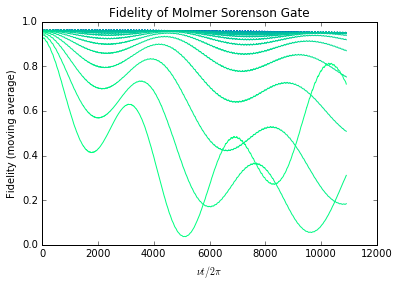

In [10]:
for i, c_1 in enumerate(c_1_values):
    print(c_1)
    MS_system = results_storage[c_1]

    t = MS_system.time_values
    t_plot = t[0:-window_size+1]
    
    signal =  moving_average(fidelity_signals[i], window_size)
    
    colorVal = scalarMap.to_rgba(colorbar_Scale[i])
    plt.plot(t_plot, signal, label=label_scale[i], color = colorVal)

# plt.legend(loc=0, fancybox=True, shadow=True, title=r"$\log \left(c_2\right)$")
plt.title("Fidelity of Molmer Sorenson Gate")
plt.ylabel("Fidelity (moving average)")
plt.xlabel(r"$ \nu t / 2 \pi$")
plt.savefig("MS_fidelity_cComparison.png")
plt.ylim(0, 1)

0.0
0.0001
0.0001279802214
0.000163789370695
0.000209617999245
0.000268269579528
0.000343332001828
0.000439397056076
0.00056234132519
0.000719685673001
0.000921055317689
0.00117876863479
0.0015085907086
0.00193069772888
0.00247091122799
0.00316227766017
0.00404708995076
0.00517947467923
0.00662870316183
0.00848342898244
0.010857111194
0.0138949549437
0.0177827941004
0.0227584592607
0.0291263265491
0.0372759372031
0.0477058269614
0.0610540229659
0.0781370737652
0.1


(0, 1)

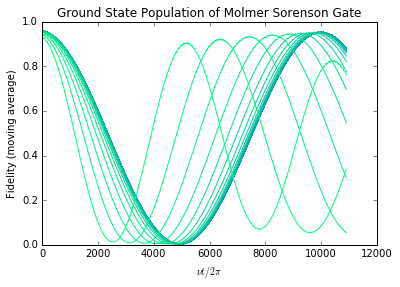

In [11]:
for i, c_1 in enumerate(c_1_values):
    print(c_1)
    MS_system = results_storage[c_1]

    t = MS_system.time_values
    t_plot = t[0:-window_size+1]
    
    signal =  moving_average(gg_population_signals[i], window_size)
    
    colorVal = scalarMap.to_rgba(colorbar_Scale[i])
    plt.plot(t_plot, signal, label=label_scale[i], color = colorVal)

# plt.legend(loc=0, fancybox=True, shadow=True, title=r"$\log \left(c_1\right)$")
plt.title("Ground State Population of Molmer Sorenson Gate")
plt.ylabel("Fidelity (moving average)")
plt.xlabel(r"$ \nu t / 2 \pi$")
plt.savefig("MS_gg_population_cComparison_c1.png")
plt.ylim(0, 1)

0.0
0.0001
0.0001279802214
0.000163789370695
0.000209617999245
0.000268269579528
0.000343332001828
0.000439397056076
0.00056234132519
0.000719685673001
0.000921055317689
0.00117876863479
0.0015085907086
0.00193069772888
0.00247091122799
0.00316227766017
0.00404708995076
0.00517947467923
0.00662870316183
0.00848342898244
0.010857111194
0.0138949549437
0.0177827941004
0.0227584592607
0.0291263265491
0.0372759372031
0.0477058269614
0.0610540229659
0.0781370737652
0.1


(0, 1)

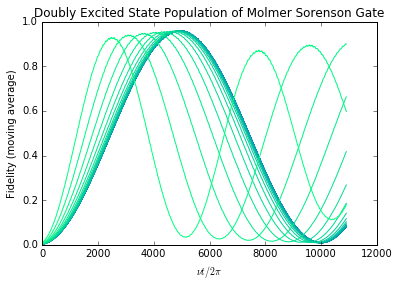

In [12]:
for i, c_1 in enumerate(c_1_values):
    print(c_1)
    MS_system = results_storage[c_1]

    t = MS_system.time_values
    t_plot = t[0:-window_size+1]
    
    signal =  moving_average(ee_population_signals[i], window_size)
    
    colorVal = scalarMap.to_rgba(colorbar_Scale[i])
    plt.plot(t_plot, signal, label=label_scale[i], color = colorVal)

# plt.legend(loc=0, fancybox=True, shadow=True, title=r"$\log \left(c_1\right)$")
plt.title("Doubly Excited State Population of Molmer Sorenson Gate")
plt.ylabel("Fidelity (moving average)")
plt.xlabel(r"$ \nu t / 2 \pi$")
plt.savefig("MS_ee_population_cComparison_c1.png")
plt.ylim(0, 1)